# GxE problem

- I updated the simulation function so that sigma is always positive (exponential)
- I am adding the decomposition of the effects

### Next steps

- Find specifications where the test would be misleading

In [ ]:
library(brms)
library(data.table)
library(texreg)

In [2]:
# scaling model 
simScaling = function(E, a0 = 0, a1 = 0.5, b0 = 0.8, b1 = 0.2, h = sqrt(0.6)) {
    N = length(E)
    G = rnorm(N,0,1)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    y = a0 + a1*E + b0*h*G + b1*h*E*G + rnorm(N, 0, sigma)
    df = data.frame(E = E, y = y, g = G)
}

# interaction model
simInteraction = function(E, a0 = 0.0, b1 = 0.5, b2 = 0.2, b3 = 0.15, sb0 = 0.1, sb1 = 0.4) {
    N = length(E)
    G = rnorm(N,0,1)
    sigma = exp(sb0 + sb0 * E) 
    y = a0 + b1*G + b2*E + b3*G*E + rnorm(N, 0, sigma)
    df = data.frame(E = E, y = y, g = G)
}

# interaction + scaling model
simScalingInteraction = function(E, a0 = 0.0,  a1 = 0.5, a2 = 0.10, b0 = 0.8, b1 = 0.2, h = sqrt(0.6)) {
    N = length(E)
    G = rnorm(N,0,1)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    y = a0 + a1*E + a2*G*E + b0*h*G + b1*h*E*G + rnorm(N, 0, sigma)
    df = data.frame(E = E, y = y, g = G)
}

## Simulating data

In [3]:
E = rnorm(5000, 0, 1)
dts = data.table(simScaling(E))
dti = data.table(simInteraction(E))
dtsi = data.table(simScalingInteraction(E))

In [4]:
cnames = c("Scaling", "Interaction", "Scaling + Interaction")
m1 = lm(y ~ g + E + g * E, data = dts)
m2 = lm(y ~ g + E + g * E, data = dti)
m3 = lm(y ~ g + E + g * E, data = dtsi)
cat(screenreg(list(m1, m2, m3), custom.model.names = cnames))


             Scaling      Interaction  Scaling + Interaction
------------------------------------------------------------
(Intercept)    -0.00        -0.00         0.00              
               (0.02)       (0.02)       (0.02)             
g               0.62 ***     0.49 ***     0.62 ***          
               (0.02)       (0.02)       (0.02)             
E               0.54 ***     0.21 ***     0.49 ***          
               (0.02)       (0.02)       (0.02)             
g:E             0.17 ***     0.15 ***     0.22 ***          
               (0.02)       (0.02)       (0.02)             
------------------------------------------------------------
R^2             0.21         0.21         0.19              
Adj. R^2        0.21         0.21         0.19              
Num. obs.    5000         5000         5000                 
*** p < 0.001; ** p < 0.01; * p < 0.05



# Bayesian distributional model


In [ ]:
# distributional model using bayesian stats
f = bf(y ~ g + E + g * E, sigma ~ 1 + E)
b1 = brm(f, data = dts, family = brmsfamily("gaussian", link_sigma = "log"))
b2 = brm(f, data = dti, family = brmsfamily("gaussian", link_sigma = "log"))
b3 = brm(f, data = dtsi, family = brmsfamily("gaussian", link_sigma = "log"))

In [7]:
# able to recover the correct sigma coefficients 
cat(screenreg(list(b1, b2, b3), custom.model.names = cnames, 
    use.HDI = TRUE,
    include.rsquared = FALSE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    include.waic = TRUE))


                 Scaling        Interaction    Scaling + Interaction
--------------------------------------------------------------------
Intercept           -0.00          -0.00           0.01             
                 [-0.04; 0.04]  [-0.03; 0.02]  [-0.04; 0.05]        
sigma_Intercept      0.48 *         0.10 *         0.52 *           
                 [ 0.46; 0.50]  [ 0.08; 0.11]  [ 0.50; 0.54]        
g                    0.62 *         0.49 *         0.62 *           
                 [ 0.58; 0.66]  [ 0.47; 0.52]  [ 0.58; 0.66]        
E                    0.54 *         0.21 *         0.50 *           
                 [ 0.50; 0.58]  [ 0.18; 0.23]  [ 0.46; 0.54]        
g:E                  0.19 *         0.15 *         0.23 *           
                 [ 0.15; 0.22]  [ 0.13; 0.18]  [ 0.19; 0.27]        
sigma_E              0.14 *         0.09 *         0.12 *           
                 [ 0.12; 0.15]  [ 0.07; 0.11]  [ 0.11; 0.14]        
---------------------------------

# Tests

## Scaling

In [38]:
# I cannot rject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b1, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0    -0.01      0.01    -0.03     0.02         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

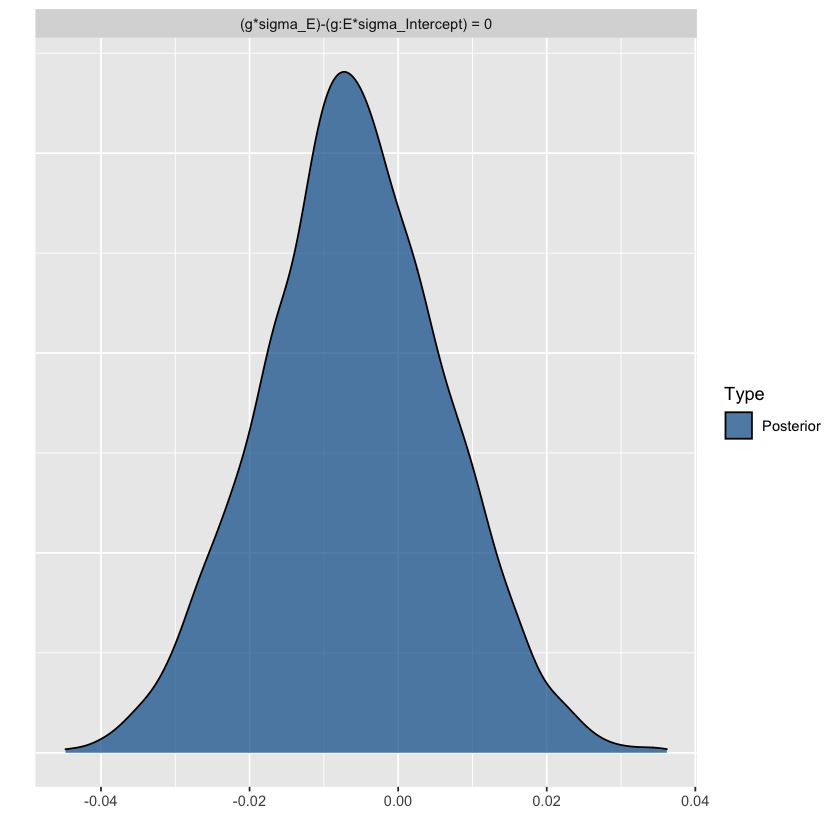

In [39]:
plot(hyp)

## Interaction

In [40]:
# I reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b2, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0     0.03      0.01     0.02     0.04         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

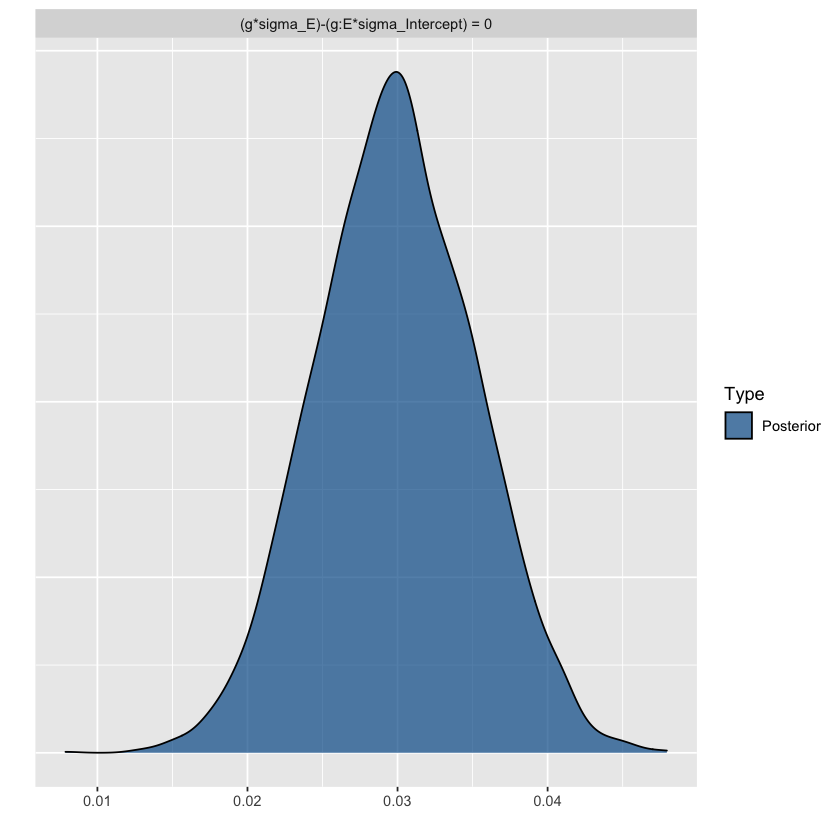

In [41]:
plot(hyp)

## Interaction + Scaling

In [42]:
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0    -0.04      0.01    -0.07    -0.02         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

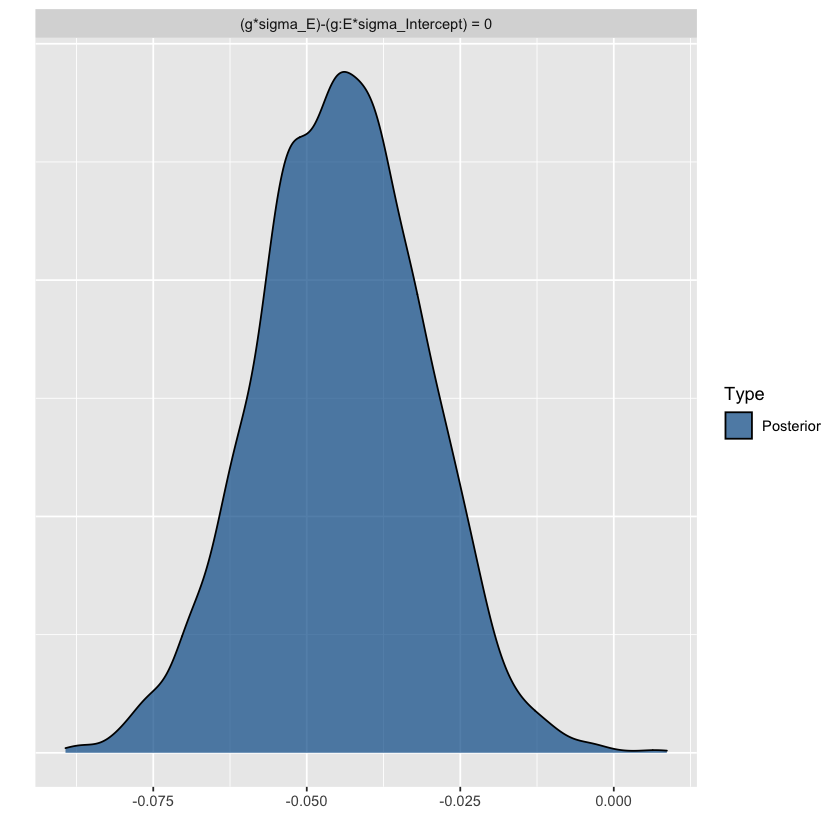

In [43]:
plot(hyp)

In [44]:
# magnitude of this departure from the scaling model as a proportion of the total GxE effect
hyp <- "(g:E / (g:E + sigma_E)) = 1.0"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 ((g:E/(g:E+sigma_... = 0    -0.35      0.03    -0.41    -0.29         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

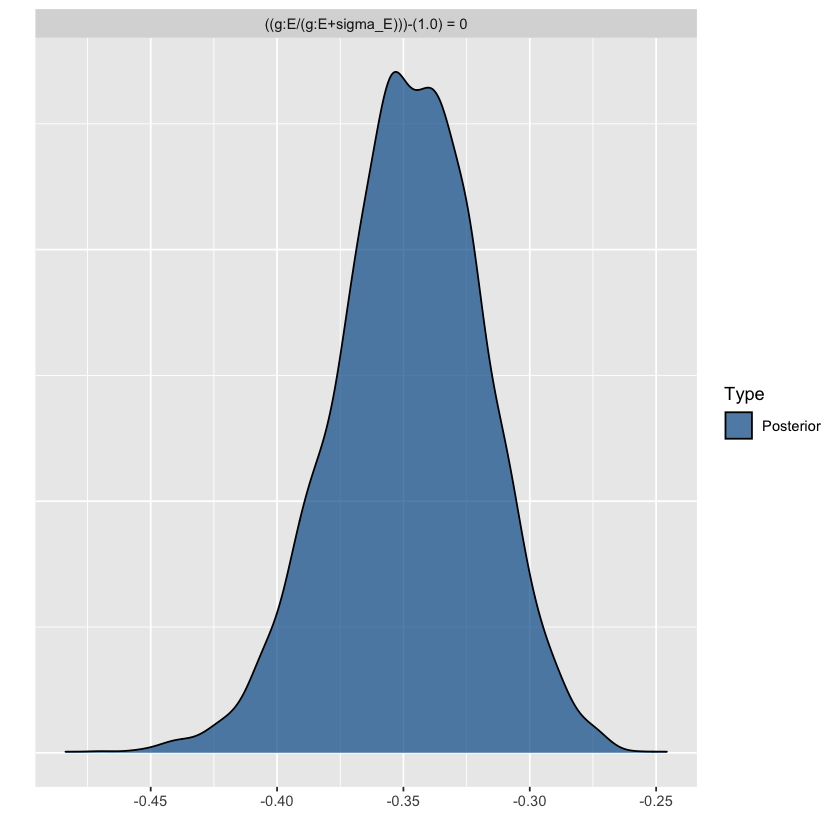

In [45]:
plot(hyp)